In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
print(c.ids)
view = c[:]
view.activate()


[0, 1]


In [20]:
%%px --block
from mpi4py import MPI 
import numpy as np

#number of procesess:

comm = MPI.COMM_WORLD
No_processes = comm.Get_size()
process_rank=comm.Get_rank()

#constants

N = 128
dt=0.00001
Niter=110
D=1
h=1./(N-1)
C=D*dt/h**2
a=0
b=0

x = np.linspace(0,1.,N)
#area:

if process_rank==0:    

    U=np.zeros(N)
    U[N//2]=1./h

else: 
    U=np.empty(N)

#subareas:
    
U_local = np.empty((N//No_processes)+2)
comm.Scatter(U, U_local[1:-1])


#computation

if process_rank==0:

    U_local[0]=a

elif process_rank==1:

    U_local[-1]=b    


for i in range(Niter):

    if process_rank==0:
        data0=U_local[-2]
        comm.send(data0, dest=1)
        U_local[-1]=comm.recv(source=1)
        
    elif process_rank==1:
        U_local[0]=comm.recv(source=0)
        data1=U_local[1]
        comm.send(data1, dest=0)
        
        
    U_local[1:-1]=U_local[1:-1]+C*(U_local[2:]+U_local[:-2]-2*U_local[1:-1])

if process_rank==0:
    U_local=U_local[1:-1]

elif process_rank==1:
    U_local=U_local[1:-1]

comm.Gather(U_local, U)

if process_rank==0:
    np.savez("Uout",U=U,x=x)



In [21]:
[u.shape for u in view['U_local']]

[(64,), (64,)]

In [22]:
import os
os.environ['HOME']

'/home/users/marcin.kostur'

In [23]:
data = np.load(os.environ['HOME']+'/Uout.npz')

In [24]:
data.files

['x', 'U']

In [25]:
U = data['U']
x = data['x']

In [26]:
U.shape

(128,)

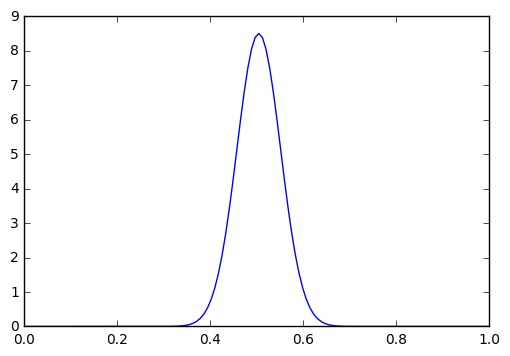

In [27]:
plt.plot(x,U)